In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import Image
from torchvision.utils import save_image
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
dataset = MNIST(root='data', train=True, download=True, transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [ ]:
def denorm(x):
    output = (x + 1) / 2
    return output.clamp(0, 1)

5


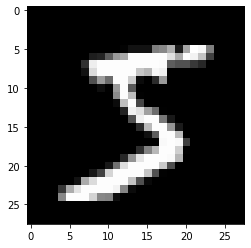

In [ ]:
image, label = dataset[0]
print(label)
image = denorm(image)
plt.imshow(image[0], cmap="gray")

In [ ]:
batch_size = 100
data_loader = DataLoader(dataset, batch_size, shuffle=True) 

torch.Size([100, 1, 28, 28])
tensor(9)


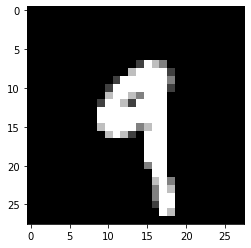

In [ ]:
for images, labels in data_loader:
    images = denorm(images)
    print(images.shape)
    print(labels[0])
    plt.imshow(images[0][0], cmap="gray")
    break

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [ ]:
latent_size = 64

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
random_noise = torch.randn(2, latent_size)
gen_img = G(random_noise)
gen_img = denorm(gen_img.reshape(-1, 28, 28)).detach()

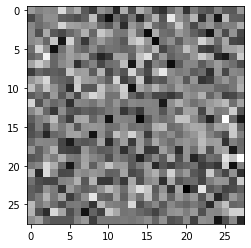

In [ ]:
plt.imshow(gen_img[0], cmap='gray')

In [ ]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [ ]:
loss_fn = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=1e-4)
G_opt = torch.optim.Adam(G.parameters(), lr=1e-4)

In [ ]:
def reset_grad():
    D_opt.zero_grad()
    G_opt.zero_grad()

def train_D(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    real_outputs = D(images)
    D_real_loss = loss_fn(real_outputs, real_labels)

    random_noise = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(random_noise)
    fake_outputs = D(fake_images)
    D_fake_loss = loss_fn(fake_outputs, fake_labels)

    D_loss = D_real_loss + D_fake_loss
    reset_grad()
    D_loss.backward()
    D_opt.step()

    return D_loss

def train_G():
    labels = torch.ones(batch_size, 1).to(device)
    random_noise = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(random_noise)
    outputs = D(fake_images)
    G_loss = loss_fn(outputs, labels)

    reset_grad()
    G_loss.backward()
    G_opt.step()

    return G_loss

In [ ]:
import os

dir_name = "samples"
if os.path.exists(dir_name) == False:
    os.makedirs(dir_name)

In [ ]:
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    images = denorm(images)
    save_image(images, os.path.join(dir_name, "real_images.png"), nrow=10)
    break

In [ ]:
Image(os.path.join(dir_name, "real_image.png"))

In [ ]:
random_noise = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(epoch_num):
    fake_images = G(random_noise)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    file_name = "fake_images-{0:0=4d}.png".format(epoch_num)
    print('Saving', file_name)
    save_image(denorm(fake_images), os.path.join(dir_name, file_name), nrow=10)

In [ ]:
save_fake_images(0)

Saving fake_images-0000.png


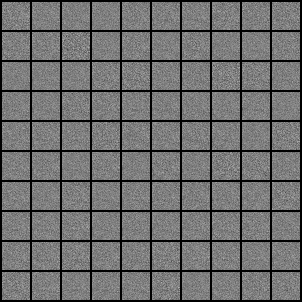

In [ ]:
Image(os.path.join(dir_name, "fake_images-0000.png"))

In [ ]:
EPOCHS = 400
step_length = len(data_loader)
D_losses = []
G_losses = []

In [ ]:
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        D_loss = train_D(images)
        G_loss = train_G()

        if (i+1)%200 == 0:
            D_losses.append(D_loss.item())
            G_losses.append(G_loss.item())
            print("Epoch: [{}/{}] | Step: [{}/{}] | D_loss: {:.4f} | G_loss : {:.4f}".format(epoch, EPOCHS, i+1, step_length, D_loss.item(), G_loss.item()))
            
    save_fake_images(epoch+1)

Epoch: [0/400] | Step: [200/600] | D_loss: 0.3372 | G_loss : 1.9935
Epoch: [0/400] | Step: [400/600] | D_loss: 0.3878 | G_loss : 2.1685
Epoch: [0/400] | Step: [600/600] | D_loss: 0.1454 | G_loss : 3.3966
Saving fake_images-0001.png
Epoch: [1/400] | Step: [200/600] | D_loss: 0.1226 | G_loss : 3.5910
Epoch: [1/400] | Step: [400/600] | D_loss: 0.3225 | G_loss : 2.6969
Epoch: [1/400] | Step: [600/600] | D_loss: 0.2112 | G_loss : 3.8987
Saving fake_images-0002.png
Epoch: [2/400] | Step: [200/600] | D_loss: 0.1432 | G_loss : 3.0604
Epoch: [2/400] | Step: [400/600] | D_loss: 0.2962 | G_loss : 3.0762
Epoch: [2/400] | Step: [600/600] | D_loss: 0.3117 | G_loss : 2.6025
Saving fake_images-0003.png
Epoch: [3/400] | Step: [200/600] | D_loss: 0.1609 | G_loss : 3.7240
Epoch: [3/400] | Step: [400/600] | D_loss: 0.4955 | G_loss : 2.2717
Epoch: [3/400] | Step: [600/600] | D_loss: 0.7613 | G_loss : 2.8376
Saving fake_images-0004.png
Epoch: [4/400] | Step: [200/600] | D_loss: 0.3399 | G_loss : 3.2792
Epoc

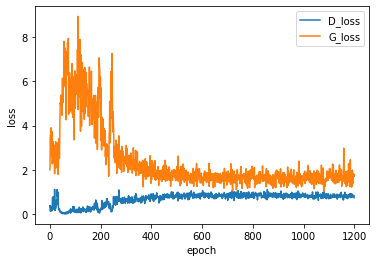

In [ ]:
plt.plot(D_losses, "-")
plt.plot(G_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["D_loss", "G_loss"])

In [ ]:
import cv2
import os
from IPython.display import FileLink

vid_name = 'gan_training.avi'

files = [os.path.join(dir_name, f) for f in os.listdir(dir_name) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_name, cv2.VideoWriter_fourcc(*'MP4V'), 8, (300,300))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training1.avi